In [2]:
import jax
import jax.numpy as np
import jax.lax as jl
import jax.random as jr
import toliman 
import toliman.constants as const
import toliman.math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import dLux
import optax
import equinox
import os

In [3]:
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams["font.size"] = 20.0
mpl.rcParams["image.cmap"] = "inferno"

true_separation: float = const.get_const_as_type("ALPHA_CENTAURI_SEPARATION", float)
true_position: float = const.get_const_as_type("ALPHA_CENTAURI_POSITION", np.ndarray)
true_pixel_scale: float = const.get_const_as_type("TOLIMAN_DETECTOR_PIXEL_SIZE", float)
true_flux: float = const.get_const_as_type("ALPHA_CENTAURI_MEAN_FLUX", float)
true_contrast: float = const.get_const_as_type("ALPHA_CENTAURI_CONTRAST", float)

os.chdir("..")

In [100]:
model: object = dLux.Instrument(
    optics = toliman.TolimanOptics(operate_in_static_mode = True),
    detector = toliman.TolimanDetector(),
    sources = [toliman.AlphaCentauri(), toliman.Background(number_of_bg_stars = 5)]
)

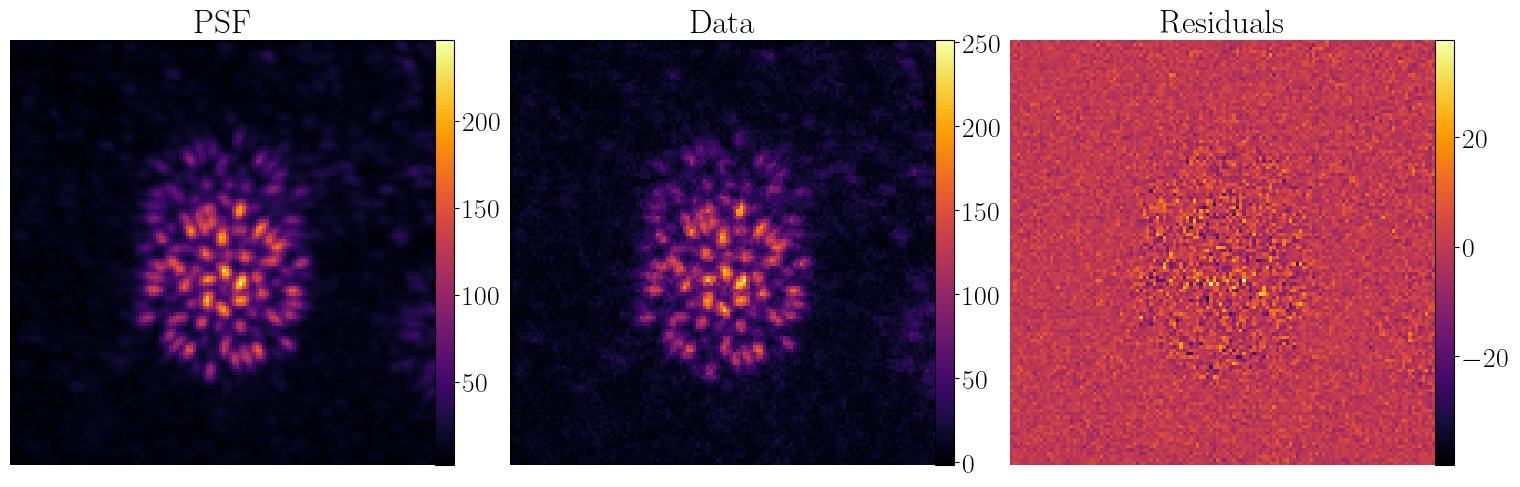

In [101]:
psf: float = model.model()
data: float = math.simulate_data(psf, 1)

def im_and_cbar(figure: object, image: float, pos: int, title: str, naxes: int) -> object:
    cbar_pad: float = 0.05
    cbar_width: float = 0.0125
    width: float = 1.0 / naxes - cbar_pad
    disp: float = cbar_pad / 2.0 * naxes
    height: float = 1.0 - 2.0 * disp
    corner: float = float(pos) / float(naxes)
    im_ax: object = figure.add_axes([corner, disp, width, height])
    cbar_ax: object = figure.add_axes([corner + width, disp, cbar_width, height])
    im_cmap: object = im_ax.imshow(image)
    im_cbar: object = figure.colorbar(im_cmap, cax = cbar_ax)
    im_xticks: object = im_ax.axis("off")
    im_title: object = im_ax.set_title(title) 
    return figure

scale: float = 5.0
naxes: int = 3
figure: object = plt.figure(figsize = (naxes * scale, scale))
figure: object = im_and_cbar(figure, psf, 1, "PSF", 3)
figure: object = im_and_cbar(figure, data, 2, "Data", 3)
figure: object = im_and_cbar(figure, data - psf, 3, "Residuals", 3)

In [10]:
params: list = [
    "BinarySource.position", 
    "BinarySource.separation", 
    "BinarySource.flux", 
    "BinarySource.contrast"
]  

perturbations: list = [
    true_pixel_scale * jr.normal(jr.PRNGKey(0), (2,)),
    5 * true_pixel_scale * jr.normal(jr.PRNGKey(0), ()),
    0.1 * true_flux * jr.normal(jr.PRNGKey(1), ()),
    0.1 * true_contrast * jr.normal(jr.PRNGKey(2), ()),
]

optimizers: list = [
    optax.adam(learning_rate = 0.005 * true_pixel_scale),
    optax.adam(learning_rate = 0.005 * true_pixel_scale),
    optax.adam(learning_rate = 0.0005 * true_flux),
    optax.adam(learning_rate = 0.0001 * true_contrast),
]

POSITION: tuple = (0, 1)
SEPARATION: int = 2
FLUX: int = 3
CONTRAST: int = 4

In [51]:
@equinox.filter_jit
@equinox.filter_value_and_grad(arg = model.get_args(paths = params))
def eval_loss(model: object, data: float) -> float:
    psf: float = model.model()
    res: float = psf - data
    sq_err: float = jl.integer_pow(res, 2)
    loss: float = jl.reduce(sq_err, 0.0, jl.add, (0, 1))
    return loss

So we want the learning rates to be a small fraction of the perturbation. At this point we need to pretend that we don't know what the perturbation is only that the perturbation is a small fraction of the true value.

In [108]:
perturbed_model: object = model.add(params, perturbations)
optimizer, opt_state = perturbed_model.get_optimiser(params, optimizers)
learning_model: object = perturbed_model # Implicit copy
full_residuals: float = np.hstack(learning_model.get(params)) - np.hstack(model.get(params))

In [59]:
with tqdm.tqdm(range(500)) as t:
    for i in t: 
        # calculate the loss and gradient
        loss, grads = eval_loss(learning_model, data) 
        
        # apply the update
        updates, opt_state = optimizer.update(grads, opt_state)
        learning_model: object = equinox.apply_updates(learning_model, updates)
        
        residuals: float = np.hstack(learning_model.get(params)) - np.hstack(model.get(params))
        full_residuals: float = np.vstack([full_residuals, residuals])
        
        t.set_description('Loss %.5f' % (loss)) # update the progress bar

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Contrast (none)')

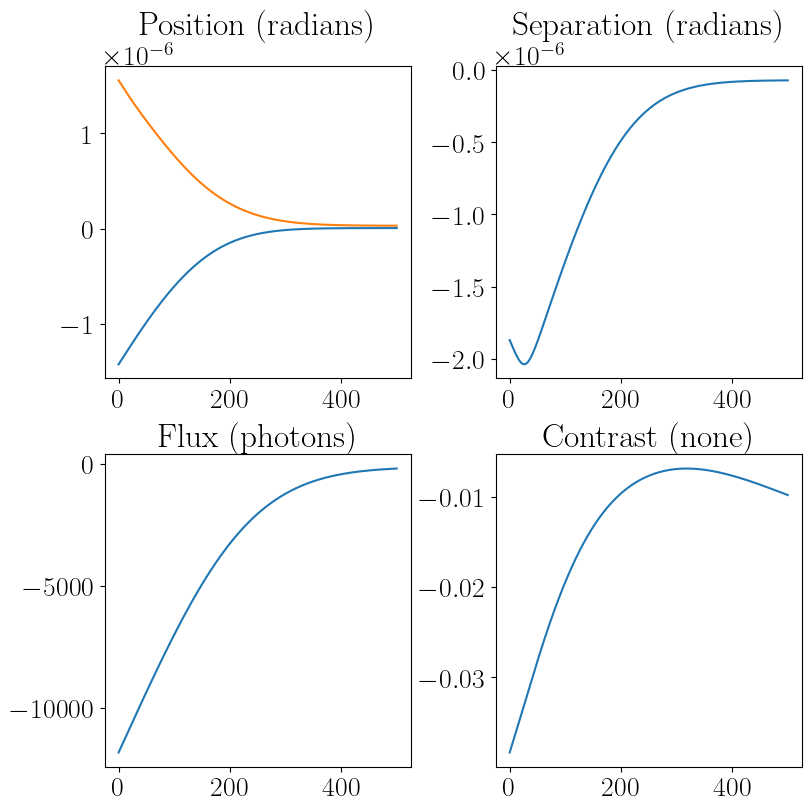

In [72]:
epochs: float = np.arange(full_residuals.shape[0])
figure: object = plt.figure(figsize=(8, 8), constrained_layout=True)
axes: object = figure.subplots(2, 2)
axes[0][0].plot(epochs, full_residuals[:, POSITION])
axes[0][0].set_title("Position (radians)")
axes[0][1].plot(epochs, full_residuals[:, SEPARATION])
axes[0][1].set_title("Separation (radians)")
axes[1][0].plot(epochs, full_residuals[:, FLUX])
axes[1][0].set_title("Flux (photons)")
axes[1][1].plot(epochs, full_residuals[:, CONTRAST])
axes[1][1].set_title("Contrast (none)")

In [212]:
shape: int = 8
x: float = jl.broadcasted_iota(float, (1, shape, shape), 1)
y: float = jl.broadcasted_iota(float, (1, shape, shape), 2)
coords: float = jl.concatenate([x, y], 0) - (shape - 1.0) / 2.0
radii: float = jl.sqrt(jl.reduce(jl.integer_pow(coords, 2), 0.0, jl.add, (0,)))

In [199]:
%%timeit
jl.select((radii > 1.0) & (radii < 2.0), jl.full_like(radii, 1.0), jl.full_like(radii, 0.0))

468 µs ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [200]:
%%timeit
((radii > 1.0) & (radii < 2.0)).astype(float)

85.6 µs ± 875 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [238]:
np.transpose(jl.expand_dims(radii, (-1,)) < jl.broadcasted_iota(float, (1, 1, shape // 2), 2)).astype(float)

Array([[[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [224]:
jl.expand_dims(radii, (-1,)).shape

(8, 8, 1)

In [218]:
radii < 2.0

Array([[False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False,  True,  True, False, False, False],
       [False, False,  True,  True,  True,  True, False, False],
       [False, False,  True,  True,  True,  True, False, False],
       [False, False, False,  True,  True, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False]],      dtype=bool)